In [18]:
import os
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime
import statsmodels as sm
import finplot as fplt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from pylab import rcParams

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

## Importing data and preprocessing

In [19]:
# Importing google data from yahoo finance
goog = yf.Ticker("GOOG")

end_date = datetime.now().strftime("%Y-%m-%d")
goog_hist = goog.history(start="2012-01-01",end=end_date)
print(goog_hist.head())


                                Open       High        Low      Close  \
Date                                                                    
2012-01-03 00:00:00-05:00  16.262545  16.641375  16.248346  16.573130   
2012-01-04 00:00:00-05:00  16.563665  16.693678  16.453827  16.644611   
2012-01-05 00:00:00-05:00  16.491436  16.537264  16.344486  16.413727   
2012-01-06 00:00:00-05:00  16.417213  16.438385  16.184088  16.189817   
2012-01-09 00:00:00-05:00  16.102144  16.114599  15.472754  15.503389   

                              Volume  Dividends  Stock Splits  
Date                                                           
2012-01-03 00:00:00-05:00  147611217        0.0           0.0  
2012-01-04 00:00:00-05:00  114989399        0.0           0.0  
2012-01-05 00:00:00-05:00  131808205        0.0           0.0  
2012-01-06 00:00:00-05:00  108119746        0.0           0.0  
2012-01-09 00:00:00-05:00  233776981        0.0           0.0  


### Seeing if all data is imported and if there any null values that need to handled

In [20]:
# Checking for null values
print("Dataframe Shape: ", goog_hist.shape)
print("Null values present: ", goog_hist.isnull().values.any())


Dataframe Shape:  (2970, 7)
Null values present:  False


## Plotting to see data

In [21]:
#fplt.candlestick_ochl(goog_hist[['Open','Close','High','Low']])
#fplt.show()

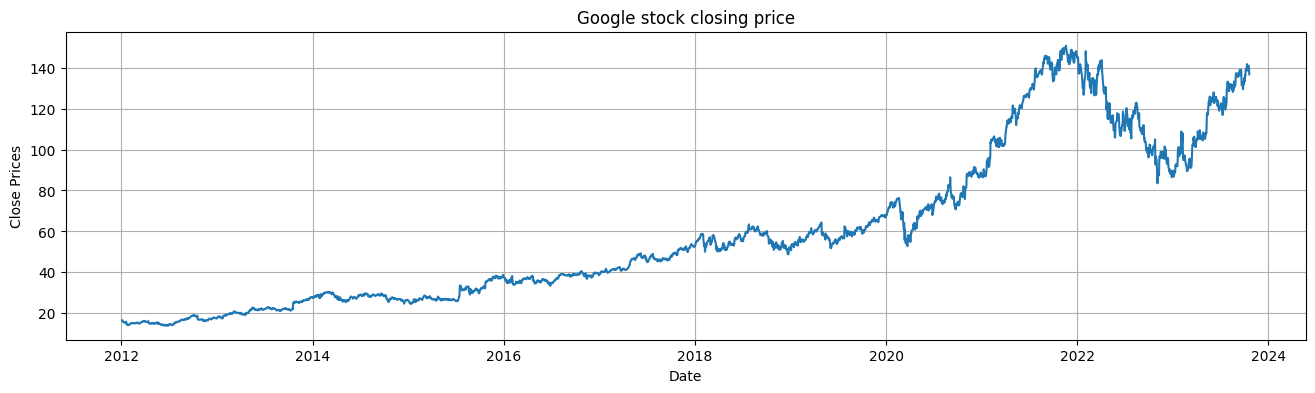

In [22]:
#Plotting Close price
plt.figure(figsize=(16,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(goog_hist['Close'],label='Close Price')
plt.title('Google stock closing price')
plt.show()

# Manually Finding p,d,q

## Finding the d for differencing 

We are testing for stationarity using the Augmented Dickey Fuller test. Our aim is for our data to be stationary by seeing if the series has a unit root.
Therefore we create a hypothesis test:

**Null Hypothesis:** The series has a unit root (value of a = 1)

**Alternative Hypothesis:** The series doesn't have a unit root

In [23]:
df_close = goog_hist['Close']

#Test for staionarity
def test_stationarity(timeseries):
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')

    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df_close)

Results of dickey fuller test
Test Statistics                   0.321867
p-value                           0.978326
No. of lags used                 23.000000
Number of observations used    2946.000000
critical value (1%)              -3.432572
critical value (5%)              -2.862522
critical value (10%)             -2.567293
dtype: float64


In these results the p-value > 0.05 as well as the test statistics exceed the critical values. Therefore the series is not stationary and further differencing needs to occur. It is stationary when the mean and standard deviation are constant throughout the series.

<Figure size 640x480 with 0 Axes>

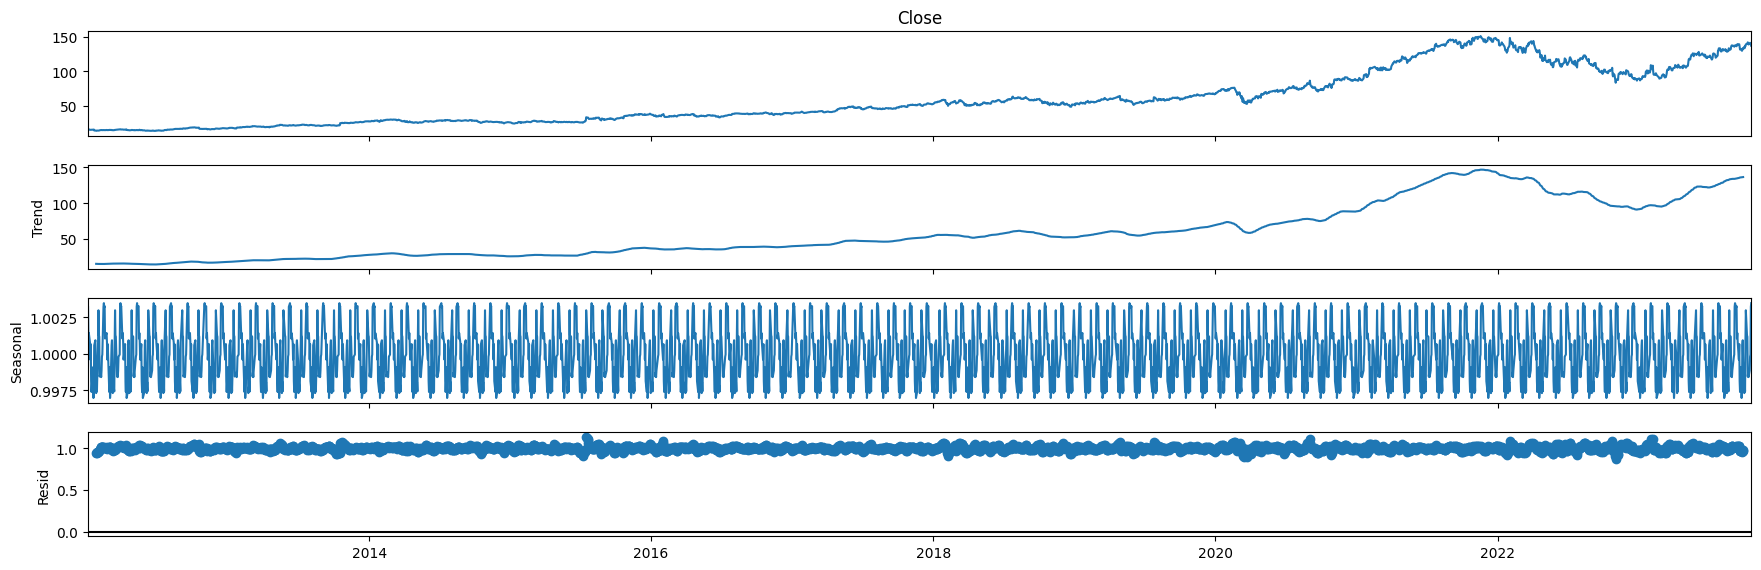

In [24]:
# To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.

result = seasonal_decompose(df_close, model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(20, 6)

Season trends can be seen when decomposing the data and hence needs to be muted. This can be done by logging the data.

In [25]:
df_log = np.log(df_close)
test_stationarity(df_log)

Results of dickey fuller test
Test Statistics                  -0.920349
p-value                           0.781197
No. of lags used                 22.000000
Number of observations used    2947.000000
critical value (1%)              -3.432571
critical value (5%)              -2.862521
critical value (10%)             -2.567292
dtype: float64


Still not stationary but these are better results and with further differencing stationarity can be achieved as shown below.

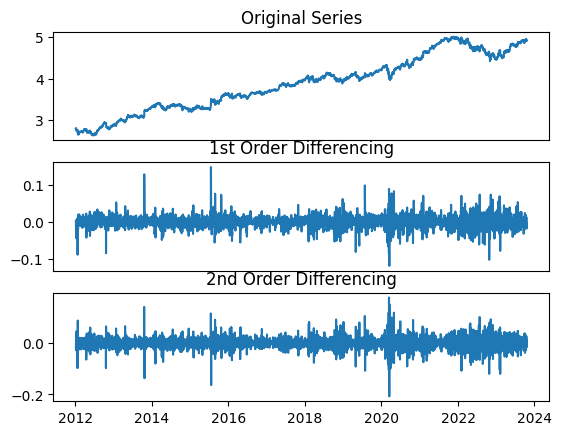

Results of dickey fuller test
Test Statistics               -1.247555e+01
p-value                        3.174401e-23
No. of lags used               2.100000e+01
Number of observations used    2.947000e+03
critical value (1%)           -3.432571e+00
critical value (5%)           -2.862521e+00
critical value (10%)          -2.567292e+00
dtype: float64


In [26]:
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(df_log); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df_log.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(df_log.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

test_stationarity(df_log.diff().dropna()) # First order differencing

## Finding p and q 

These can be found using the ACF and PACF tests. What can be seen below is the ACF plot. The shaded area (cone) is the confidence level and is set to 95% which means that if the points are outside this area then you can say with 95% certainty that they have an impact on the values. If the point is inside the area then it can be said that it not relevevant and may be ignored. The aim is remove these highly impactful points therefore:

**Finding q:** Take the number of lags that are greatly outside the significance limit in the ACF -- order(1) in example

**Finding p:** Take the number of lags that are greatly outside the significance limit in the PACF -- order(1) in example

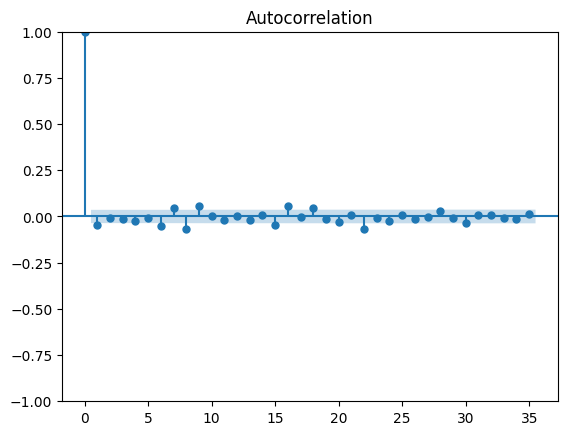

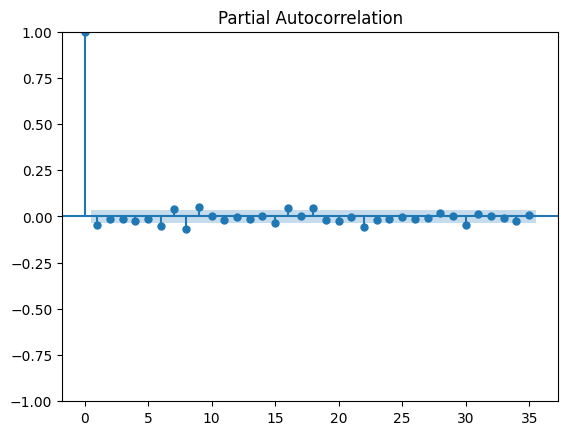

In [27]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

#data: your time series
#lags: number of 'periods' you will like to investigate 
# acf and pacf after differencing once

acf = plot_acf(df_log.diff().dropna())
pacf = plot_pacf(df_log.diff().dropna())

# Creating the model
### Seperating the training and testing data

Seperating the training and testing data allows us to validate our model. So 90% of the data has been used for training while the remaining 10% has been used for the test data

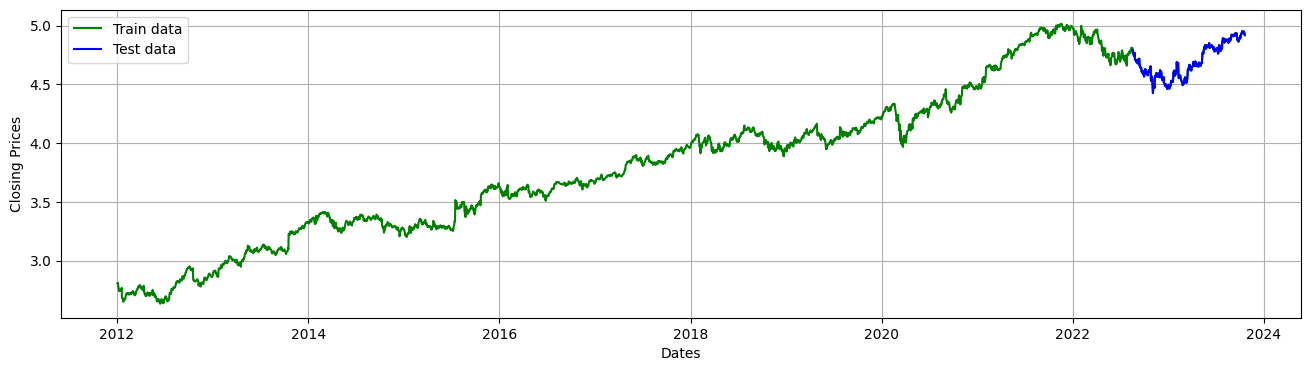

In [28]:
#split data into train and training set
train_data, test_data = df_log[:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(16,4))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


## Automatic optimal parameters 

Importing an R statistical package can actully allow us to automatically find the 'best' parameters. It savea a lot of time but it is not always best to fully understand the process that is inolved and while it can always give 'good' results doesn't necessarily mean that there aren't equally or even better parameters to choose from.

In the end we get these values from the auto ARIMA:

p = 1

d = 0

q = 1

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14372.038, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14379.615, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14379.505, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14368.492, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-14377.687, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14377.753, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-14375.660, Time=0.83 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-14375.376, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 2.465 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2673
Model:               SARIMAX(1, 1, 0)   Log Likelihood                7192.807
Date:                Sat, 21 Oct 2023   AIC                         -14379.615
Time:               

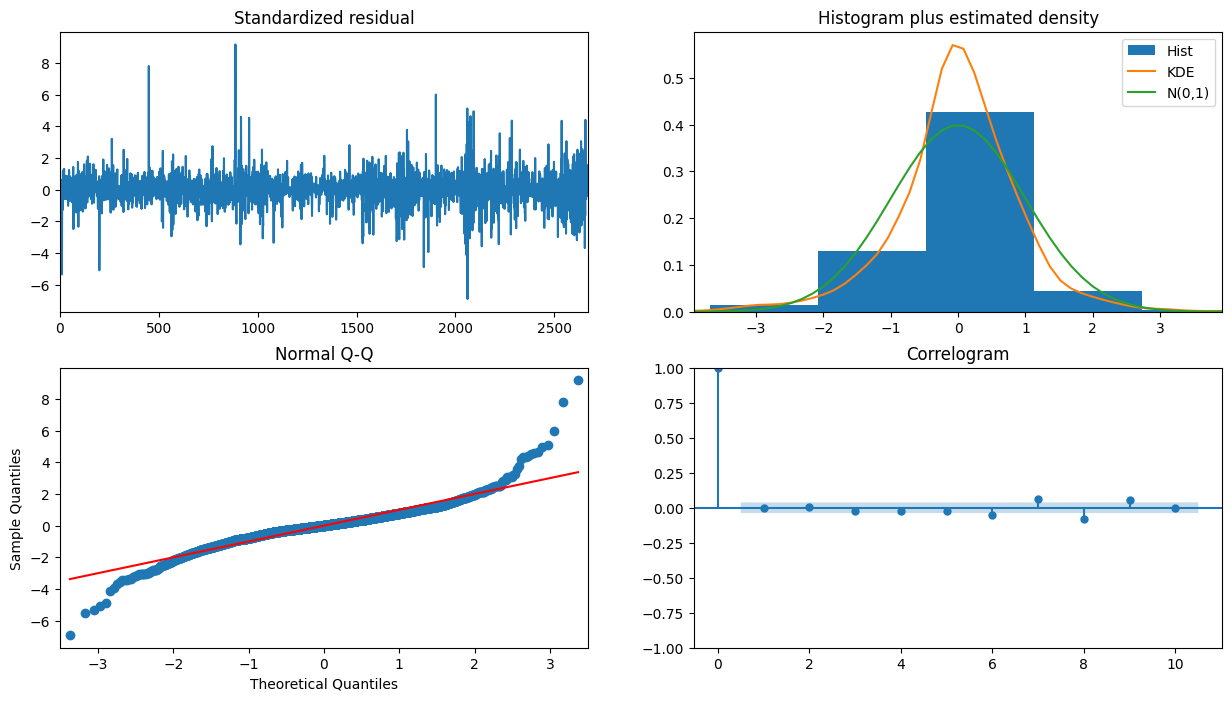

In [29]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

We can also see the statistic diagnostics which is another benefit of using the Auto ARIMA. Here is a table explaining each 

|        | Left                                                                                 | Right                                                                                                                                                |
|--------|--------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------|
| Top    | Residual error with uniform variance around the mean 0.                              | Data follows a normal distribution with mean 0.                                                                                                      |
| Bottom | Q-Q plot reaffirms that this is a normal distribution as it follows a straight line. | ACF plot of the residual errors shows they are not autocorrelated, meaning that any residual error has a pattern that can be explained by the model. |

### Building model with picked parameters

In [34]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,0))  
fitted = model.fit() 
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2673
Model:                 ARIMA(1, 1, 0)   Log Likelihood                7189.688
Date:                Sat, 21 Oct 2023   AIC                         -14375.376
Time:                        15:30:17   BIC                         -14363.595
Sample:                             0   HQIC                        -14371.113
                               - 2673                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0576      0.013     -4.564      0.000      -0.082      -0.033
sigma2         0.0003   3.28e-06     82.238      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.01   Jarque-

# Results

Once the model has been build and trained with the necessary data we are able to get the forecast trend. This will can also give us the confidence interval. A slight change to the date time index will allow us to plot it against the test data in order to see how accurate it is.

In [37]:
fc = fitted.get_forecast(steps=len(test_data), alpha=0.05).summary_frame()
fc.set_index([test_data.index], inplace=True)
print(fc)


Close                          mean   mean_se  mean_ci_lower  mean_ci_upper
Date                                                                       
2022-08-17 00:00:00-04:00  4.808366  0.016413       4.776198       4.840535
2022-08-18 00:00:00-04:00  4.808356  0.022552       4.764155       4.852558
2022-08-19 00:00:00-04:00  4.808357  0.027377       4.754699       4.862015
2022-08-22 00:00:00-04:00  4.808357  0.031469       4.746678       4.870036
2022-08-23 00:00:00-04:00  4.808357  0.035088       4.739587       4.877127
...                             ...       ...            ...            ...
2023-10-16 00:00:00-04:00  4.808357  0.265682       4.287629       5.329085
2023-10-17 00:00:00-04:00  4.808357  0.266135       4.286742       5.329972
2023-10-18 00:00:00-04:00  4.808357  0.266587       4.285856       5.330858
2023-10-19 00:00:00-04:00  4.808357  0.267038       4.284971       5.331743
2023-10-20 00:00:00-04:00  4.808357  0.267489       4.284088       5.332626

[297 rows x

### Plotting results

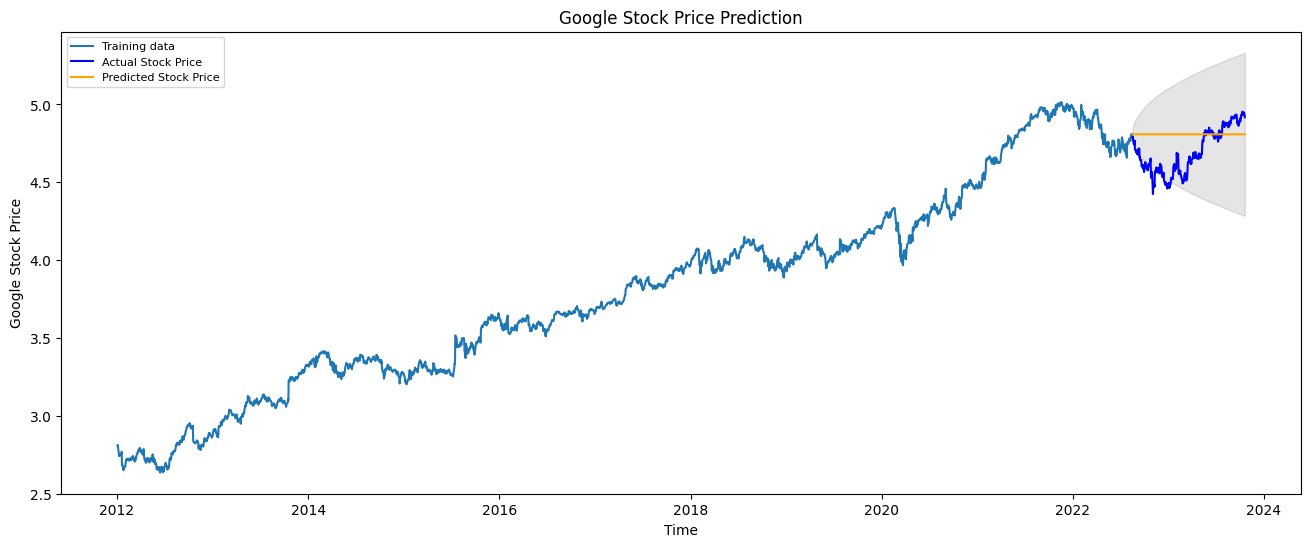

In [38]:
predicted = fc['mean']
lower_conf = fc['mean_ci_lower']
upper_conf = fc['mean_ci_upper']

# Plot
plt.figure(figsize=(16,6), dpi=100)
plt.plot(train_data, label='Training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(predicted, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_conf.index, lower_conf, upper_conf, color='k', alpha=.10)
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Currently the forecast shows that there will be a downward trend over the next year which we can visually see is true for the test data. We can confirm that accuracy of the model by calculating the error against the test data. Using standard formulas we can calculate the mean square error, mean absolute error, root mean square error and mean absolute percentage error.

Therefore we can conclude that this model has accuracy of 96.9% based on the MAPE being 3.14%

In [33]:
# report performance
mse = mean_squared_error(test_data, predicted)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, predicted)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, predicted))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(predicted - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.030924585448603745
MAE: 0.15795410638211912
RMSE: 0.17585387527320445
MAPE: 0.033957326447489077
